# Image Metadata Retrieval with ThanoSQL

## Introduction
Managing and retrieving large image datasets is a common challenge for photographers, art galleries, and companies involved in poster production or exhibitions. This use case will guide you through the process of using ThanoSQL to handle and query large datasets of images and their metadata. By the end of this use case, you will be able to search for images based on both image and text inputs and retrieve detailed metadata about the images, such as dimensions and photographer information.

## Running the Tutorial in Different Environments
This tutorial can be executed both within ThanoSQL Lab and in a local Python/Jupyter environment. Whether you prefer to work directly within ThanoSQL Lab's integrated environment or set up a local development environment on your machine, the instructions provided will guide you through the necessary steps.

## Dataset
We will be working with two datasets:

- **Unsplash Embedding Sample Table (unsplash_embed_sample)**: Contains detailed metadata about the images including information about the photographer, camera settings, and location.
  - `photo_id`: Unique identifier for each photo.
  - `photo_url`: URL of the photo on Unsplash.
  - `photo_image_url`: URL of the photo image.
  - `photo_submitted_at`: Date when the photo was submitted.
  - `photo_featured`: Indicates if the photo is featured.
  - `photo_width`: Width of the photo in pixels.
  - `photo_height`: Height of the photo in pixels.
  - `photo_aspect_ratio`: Aspect ratio of the photo.
  - `photo_description`: Description of the photo.
  - `photographer_username`: Username of the photographer.
  - `photographer_first_name`: First name of the photographer.
  - `photographer_last_name`: Last name of the photographer.
  - `exif_camera_make`: Camera make.
  - `exif_camera_model`: Camera model.
  - `exif_iso`: ISO setting of the camera.
  - `exif_aperture_value`: Aperture value.
  - `exif_focal_length`: Focal length.
  - `exif_exposure_time`: Exposure time.
  - `photo_location_name`: Name of the photo location.
  - `photo_location_latitude`: Latitude of the photo location.
  - `photo_location_longitude`: Longitude of the photo location.
  - `photo_location_country`: Country of the photo location.
  - `photo_location_city`: City of the photo location.
  - `stats_views`: Number of views.
  - `stats_downloads`: Number of downloads.
  - `ai_description`: AI-generated description of the photo.
  - `ai_primary_landmark_name`: AI-generated primary landmark name.
  - `ai_primary_landmark_latitude`: Latitude of the AI-generated primary landmark.
  - `ai_primary_landmark_longitude`: Longitude of the AI-generated primary landmark.
  - `ai_primary_landmark_confidence`: Confidence of the AI-generated primary landmark.
  - `blur_hash`: Blur hash of the image.
- **Unsplash Metadata Sample Table (unsplash_meta_sample)**: Contains image paths and their corresponding embeddings.
  - `photo_id`: Unique identifier for each photo.
  - `image_path`: Path to the image.
  - `embedding`: Embedding vector of the image.


    
## Goals
1. Obtain photo files and their metadata (e.g., photo dimensions, photographer names).
2. Perform advanced queries on both structured and unstructured data using ThanoSQL to retrieve the desired metadata.

## Tokens 
To run the models in this tutorial, you will need the following tokens:
- **OpenAI Token**: Required to access all the OpenAI-related tasks when using OpenAI as an engine. This token enables the use of OpenAI's language models for various natural language processing tasks.
- **Huggingface Token**: Required only to access gated models such as Mistral on the Huggingface platform. Gated models are those that have restricted access due to licensing or usage policies, and a token is necessary to authenticate and use these models. For more information, check this [Huggingface documentation](https://huggingface.co/docs/hub/en/models-gated).
Make sure to have these tokens ready before proceeding with the tutorial to ensure a smooth and uninterrupted workflow.

## Install Required Libraries 
This command installs the Pillow and matplotlib libraries, which are necessary for image processing and display.

In [ ]:
!pip install pillow matplotlib

## Displaying ThanoSQL Query Results in Jupyter Notebooks
The check_result function is designed to handle and display the results of a database query executed via the ThanoSQL client. It ensures that any errors are reported, and successful query results are displayed in a user-friendly format.

**Note: This function is specifically designed to work in Jupyter notebook environments.**

In [1]:
from IPython.display import display

def check_query_result(query_result):
    if query_result.error_result:
        print(query_result.error_result)
    else:
        if query_result.records is not None and len(query_result.records.data) > 0:
            df = query_result.records.to_df()
            display(df)
        else:
            print("Query executed successfully")

## Displaying Images in Jupyter Notebooks

This function, `show_images`, displays images from URLs. It accepts either a single URL or a DataFrame containing multiple URLs. The function fetches each image using the URL, processes it using PIL, and then displays it using matplotlib.

In [2]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd

def show_images(input, image_column_name=None):
    """
    Display images from URLs. The input can be either a single URL or a DataFrame containing multiple URLs.
    vs
    Args:
        input (str or DataFrame): Single image URL or DataFrame containing image URLs.
        image_column_name (str): The column name containing image URLs if input is a DataFrame.
    """
    # Check if the input is a DataFrame
    if isinstance(input, pd.DataFrame):
        df = input
        num_images = len(df)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        
        if num_images == 1:
            axes = [axes]
        
        for idx, (image_url, ax) in enumerate(zip(df[image_column_name], axes)):
            response = requests.get(image_url)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content))
            ax.imshow(image)
            ax.axis('off')
    
    # If the input is a single URL
    elif isinstance(input, str):
        fig, ax = plt.subplots(figsize=(5, 5))
        response = requests.get(input)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        ax.imshow(image)
        ax.axis('off')

    else:
        raise ValueError("Input must be either a DataFrame or a single image URL (str).")
    
    plt.tight_layout()
    plt.show()

## Procedure

### Download Datasets

First, we will download and load the datasets into pandas DataFrames and display their shapes to understand the structure and size of the data.

In [3]:
!wget -O use_case_2_data.zip https://raw.githubusercontent.com/smartmind-team/assets/main/datasets/use_cases/use_case_2_data.zip

--2024-06-28 05:45:37--  https://raw.githubusercontent.com/smartmind-team/assets/main/datasets/use_cases/use_case_2_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2656 (2.6K) [application/zip]
Saving to: ‘use_case_2_data.zip’

use_case_2_data.zip 100%[===================>]   2.59K  --.-KB/s    in 0s      

2024-06-28 05:45:37 (41.9 MB/s) - ‘use_case_2_data.zip’ saved [2656/2656]



In [4]:
!unzip -o use_case_2_data.zip

Archive:  use_case_2_data.zip
  inflating: unsplash_embed_sample.csv  
  inflating: unsplash_meta_sample.csv  


In [5]:
import pandas as pd
unsplash_embed_sample = pd.read_csv("unsplash_embed_sample.csv")
unsplash_meta_sample = pd.read_csv("unsplash_meta_sample.csv")   

print("unsplash_meta_sample:", unsplash_meta_sample.shape, "unsplash_embed_sample:", unsplash_embed_sample.shape)

unsplash_meta_sample: (10, 31) unsplash_embed_sample: (10, 2)


This step loads the datasets into pandas DataFrames and prints their shapes to give an overview of the data size and structure.

### Import ThanoSQL Library

Next, we need to import the ThanoSQL library and create a client instance. This client will be used to interact with the ThanoSQL engine.

**You can find your API Token and Engine URL by following these steps:**

1. Go to your workspace’s settings page.
2. Navigate to the "Developer" tab.
3. Locate and copy your API Token and Engine URL.

In [6]:
from thanosql import ThanoSQL
client = ThanoSQL(api_token="your_api_token", engine_url="engine_url")

### Upload Data to Tables

We upload the `unsplash_embed_sample` table to ThanoSQL. This table contains image paths and their corresponding embeddings.

In [7]:
table = client.table.upload('unsplash_embed_sample', 'unsplash_embed_sample.csv', if_exists='replace')
table.get_records(limit=10).to_df()

,photo_id,photo_url
0,bygTaBey1Xk,https://unsplash.com/photos/bygTaBey1Xk
1,gXSFnk2a9V4,https://unsplash.com/photos/gXSFnk2a9V4
2,grg6-DNJuaU,https://unsplash.com/photos/grg6-DNJuaU
3,sO42hhChB1c,https://unsplash.com/photos/sO42hhChB1c
4,tkk8_HakQ98,https://unsplash.com/photos/tkk8_HakQ98
5,aDUZbFgW3u4,https://unsplash.com/photos/aDUZbFgW3u4
6,whOkVvf0_hU,https://unsplash.com/photos/whOkVvf0_hU
7,fUbtdL_adv0,https://unsplash.com/photos/fUbtdL_adv0
8,Sf8g7a3duRY,https://unsplash.com/photos/Sf8g7a3duRY
9,Nw8j0pBvRWg,https://unsplash.com/photos/Nw8j0pBvRWg


This step uploads the `unsplash_embed_sample` data to ThanoSQL and retrieves the first 10 records to confirm the upload.

Similarly, we upload the `unsplash_meta_sample` table which contains detailed metadata about the images.

In [8]:
table = client.table.upload('unsplash_meta_sample', 'unsplash_meta_sample.csv', if_exists='replace')
table.get_records(limit=10).to_df()

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,bygTaBey1Xk,https://unsplash.com/photos/bygTaBey1Xk,https://images.unsplash.com/uploads/1413387620...,2014-10-15,t,4635,3070,1.51,None,jaspervandermeij,...,None,None,1708356,19085,sea and rock cliff with grasses under cloudy sky,Neist Point,57.428387,-6.783028,30.348906,LcE{wnIVRixt~WR+NGjbxukCWBWB
1,gXSFnk2a9V4,https://unsplash.com/photos/gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...,2014-07-10,t,2448,3264,0.75,Coastline view,kimberlyrichards,...,United States,Tillamook,9895033,74702,aerial photography of seashore,None,NaN,NaN,NaN,LXE4G#IARjj]GdWFxaWBDOxaofj[
2,grg6-DNJuaU,https://unsplash.com/photos/grg6-DNJuaU,https://images.unsplash.com/uploads/1412192004...,2014-10-01,t,5184,3456,1.50,None,marcusdallcol,...,None,None,8967968,38338,man surfboarding on ocean wave during daytime,None,NaN,NaN,NaN,LcHx?5R%Rjof01bHWBof4ooMoeax
3,sO42hhChB1c,https://unsplash.com/photos/sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...,2014-08-19,t,4896,3264,1.50,Hazy Ocean Waters,arturpokusin,...,None,None,2071752,10860,body of water,None,NaN,NaN,NaN,LyOzVsj[aefQ_4j[ayj[IUayj[ay
4,tkk8_HakQ98,https://unsplash.com/photos/tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...,2014-05-05,t,2000,1333,1.50,Silhouettes In Desert,carlov,...,None,None,2720281,9081,car on desert during sunset,None,NaN,NaN,NaN,"LYEV]I%19ZR+-=s,RkWW00WB%2j["
5,aDUZbFgW3u4,https://unsplash.com/photos/aDUZbFgW3u4,https://images.unsplash.com/photo-141534083939...,2014-11-07,t,6016,4016,1.50,Smooth rocks under a bridge,timmossholder,...,UAA,"Bend, OR",1396901,8001,body of water near bridge during daytime,None,NaN,NaN,NaN,LZG[ylIU9Foy~pE0aft7_3RPRjR*
6,whOkVvf0_hU,https://unsplash.com/photos/whOkVvf0_hU,https://images.unsplash.com/photo-143126315497...,2015-05-10,t,4272,2848,1.50,White lilac,veri_ivanova,...,None,None,36535677,243745,white flowers,None,NaN,NaN,NaN,LHJkv7_49GR%?cD%axt79ZxuWBWB
7,fUbtdL_adv0,https://unsplash.com/photos/fUbtdL_adv0,https://images.unsplash.com/photo-143116202015...,2015-05-09,t,3264,2448,1.33,Sea of dunes,chiara,...,None,None,3359379,15447,desert during daytime,None,NaN,NaN,NaN,"LuHL9$Ips,oL?ww^WCWW?cIqs.WW"
8,Sf8g7a3duRY,https://unsplash.com/photos/Sf8g7a3duRY,https://images.unsplash.com/photo-143992327406...,2015-08-18,t,6016,3399,1.77,None,anfalshams,...,India,Anchal,10891770,105745,blue and black starry skies,None,NaN,NaN,NaN,L51gcgpyZ}aKpJo#adazi^jEaya|
9,Nw8j0pBvRWg,https://unsplash.com/photos/Nw8j0pBvRWg,https://images.unsplash.com/photo-143879750899...,2015-08-05,t,3500,2336,1.50,None,tashography,...,None,None,729601,3582,brown mountain near trees low angle photograph,None,NaN,NaN,NaN,LpDTn~j]XTfkpfayRjay9ZayaJkC


This step uploads the `unsplash_meta_sample` data to ThanoSQL and retrieves the first 10 records to confirm the upload.

### Create Embedding Column

To store the embedding vectors, we need to create an embedding column in the `unsplash_embed_sample` table.

In [9]:
query_result = client.query.execute(
    """
    CREATE EXTENSION IF NOT EXISTS vector;

    ALTER TABLE unsplash_embed_sample
    ADD COLUMN IF NOT EXISTS embedding vector(512)
    """
)
check_query_result(query_result)

Query executed successfully


This step ensures that the `vector` extension is available and adds an embedding column to the `unsplash_embed_sample` table if it does not already exist.

### Embed Images

Now, we calculate and update the embedding vectors for the images in the `unsplash_embed_sample` table using a pre-trained model.

In [10]:
query_result = client.query.execute(
    """
    -- This query calculates embeddings for each photo URL using a specified model and saves it to the specified table
    WITH calculated_embeddings AS (
        -- Step 1: Calculate embeddings
        SELECT
            photo_url,
            thanosql.embed(
                engine := 'huggingface',           
                input := photo_url,                
                model := 'openai/clip-vit-base-patch32' 
            ) AS embedding                        
                -- Alias the result of the embedding function as 'embedding'
        FROM
            unsplash_embed_sample                
    )
    -- Step 2: Update the original table with the calculated embeddings
    UPDATE unsplash_embed_sample
    SET 
        embedding = calculated_embeddings.embedding 
            -- Set the 'embedding' column with the calculated embeddings
    FROM 
        calculated_embeddings                    
            -- Use the 'calculated_embeddings' as the source for the new values
    WHERE
        unsplash_embed_sample.photo_url = calculated_embeddings.photo_url;
            -- Ensure that each row in 'unsplash_embed_sample' is matched with the corresponding row in 'calculated_embeddings' 
            -- by matching the 'photo_url' column in both tables
    """
)
check_query_result(query_result)

Query executed successfully


### Search by Image
In this section, we'll perform a similarity search using an example image. We will retrieve the embedding vector for an image of a coastal cliff and then use that vector to find similar images.

This calls the `show_images` function with a single image URL of a coastal cliff which will be used to search similar images from the sample dataset. It will display the image inline in the notebook.

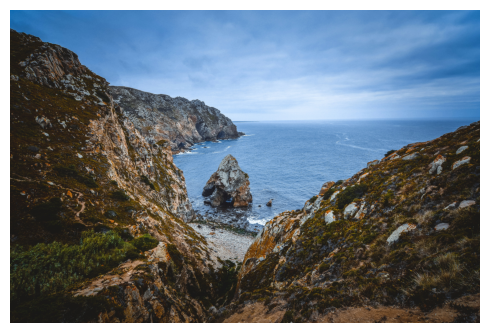

In [11]:
show_images('https://images.unsplash.com/photo-1506887419028-47afaf38c27e')

This query retrieves the three most similar images to the example image based on their embeddings with the detailed metadata for the images.

In [12]:
query_result = client.query.execute(
    """
    -- This query calculates the embedding for a specific image URL, finds the top 3 similar images in the database,
    -- and retrieves their metadata from the 'unsplash_meta_sample' table.
    WITH calculated_embeddings AS (
        -- Step 1: Calculate embedding for the specific image URL
        SELECT 
            thanosql.embed(
                engine := 'huggingface',           
                input := 'https://images.unsplash.com/photo-1506887419028-47afaf38c27e', 
                model := 'openai/clip-vit-base-patch32' 
            ) AS embedding                        
                -- Alias the result of the embedding function as 'embedding'
    )
    -- Step 2: Select metadata of the top 3 similar images
    SELECT 
        photo_id,                      
        photo_image_url,               
        photo_submitted_at,            
        photo_width,                   
        photo_height,                  
        photographer_username,         
        photographer_first_name,       
        photographer_last_name,        
        exif_camera_make,              
        exif_camera_model,             
        exif_iso,                      
        exif_aperture_value,           
        exif_focal_length,             
        exif_exposure_time             
    FROM 
        unsplash_meta_sample
    WHERE 
        photo_id IN (
            -- Step 3: Retrieve the top 3 similar images based on embedding similarity
            SELECT 
                photo_id
            FROM 
                unsplash_embed_sample
            ORDER BY 
                embedding <-> (
                    SELECT embedding FROM calculated_embeddings 
                        -- Calculate distance to the specific image's embedding
                )
            LIMIT 3                    
                -- Limit to the top 3 similar images
        );
    """
)
df = query_result.records.to_df()
df

,photo_id,photo_image_url,photo_submitted_at,photo_width,photo_height,photographer_username,photographer_first_name,photographer_last_name,exif_camera_make,exif_camera_model,exif_iso,exif_aperture_value,exif_focal_length,exif_exposure_time
0,gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...,2014-07-10,2448,3264,kimberlyrichards,Kimberly,Richards,Apple,iPhone 5,50.0,2.4,4.1,1/2358
1,sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...,2014-08-19,4896,3264,arturpokusin,Artur,Pokusin,FUJIFILM,X100S,1600.0,5.6,23.0,1/170
2,tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...,2014-05-05,2000,1333,carlov,Carlo,V.,Canon,Canon EOS 5D Mark III,400.0,16.0,35.0,1/400


#### Display Retrieved Images
We can now display the retrieved images using the metadata.


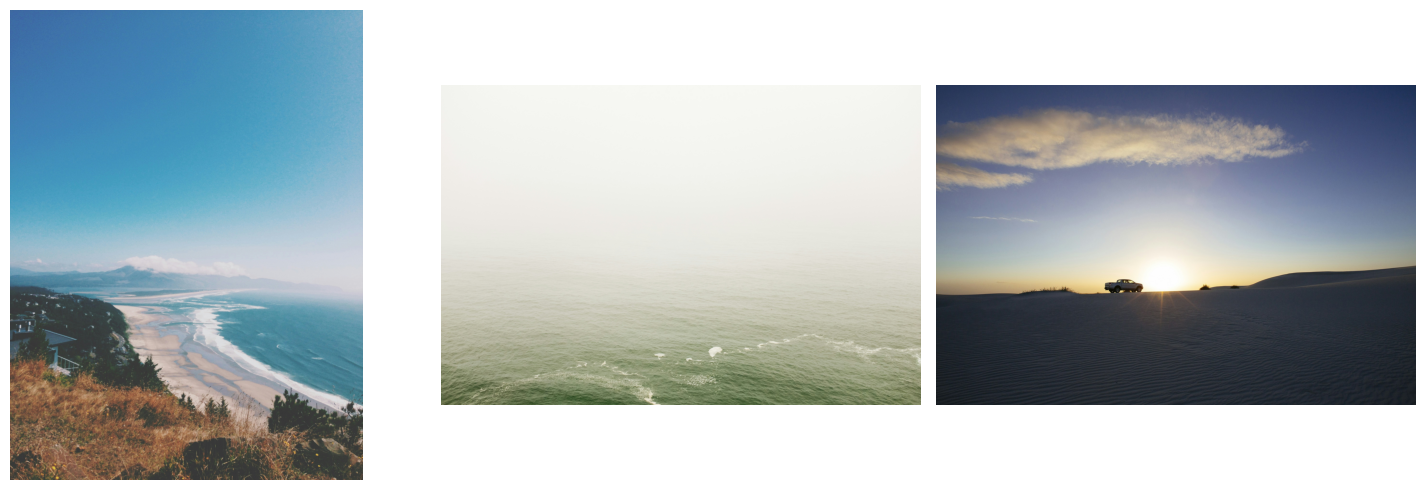

In [13]:
show_images(df, 'photo_image_url')

### Search by Text

We can also perform a similarity search using a text description. Here, we search for the image that is most similar to the description "a photo of the desert".

In [14]:
query_result = client.query.execute(
    """
    -- This query calculates the embedding for a description of an image ('a photo of the desert'), finds the most similar image in the database,
    -- and retrieves its metadata from the 'unsplash_meta_sample' table.
    WITH calculated_embeddings AS (
        -- Step 1: Calculate embedding for the given description
        SELECT 
            thanosql.embed(
                engine := 'huggingface',           
                input := 'a photo of the desert',  
                model := 'openai/clip-vit-base-patch32' 
            ) AS embedding                        
                -- Alias the result of the embedding function as 'embedding'
    )
    -- Step 2: Select metadata of the most similar image
    SELECT 
        photo_id,                      
        photo_image_url,               
        photo_submitted_at,            
        photo_width,                   
        photo_height,                  
        photographer_username,         
        photographer_first_name,       
        photographer_last_name,        
        exif_camera_make,              
        exif_camera_model,             
        exif_iso,                      
        exif_aperture_value,           
        exif_focal_length,             
        exif_exposure_time             
    FROM 
        unsplash_meta_sample
    WHERE 
        photo_id IN (
            -- Step 3: Retrieve the most similar image based on embedding similarity
            SELECT 
                photo_id
            FROM 
                unsplash_embed_sample
            ORDER BY 
                embedding <-> (
                    SELECT embedding FROM calculated_embeddings 
                        -- Calculate distance to the embedding of the description
                )
            LIMIT 1                    
                -- Limit to the single most similar image
        );
    """
)
df = query_result.records.to_df()
df

,photo_id,photo_image_url,photo_submitted_at,photo_width,photo_height,photographer_username,photographer_first_name,photographer_last_name,exif_camera_make,exif_camera_model,exif_iso,exif_aperture_value,exif_focal_length,exif_exposure_time
0,fUbtdL_adv0,https://images.unsplash.com/photo-143116202015...,2015-05-09,3264,2448,chiara,Chiara,Ferroni,None,None,None,None,None,None


#### Display Retrieved Images
Finally, we display the retrieved image.
                           

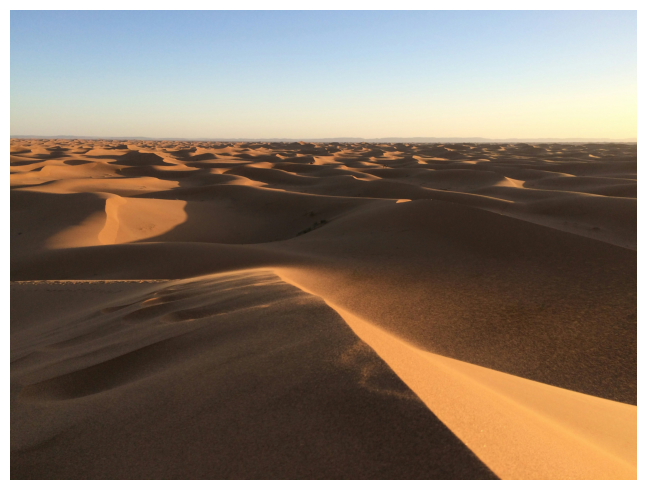

In [15]:
show_images(df, 'photo_image_url')

This code fetches and displays the image using its URL from the metadata.

## Conclusion
By following these steps, you will be able to efficiently manage and retrieve image metadata from large datasets using ThanoSQL. This capability is invaluable for various applications, including art exhibitions, poster production, and digital asset management. The ability to perform both image-based and text-based searches enables a flexible and powerful approach to handling visual data.
